# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 15
### <center> Yoshihiro Shirai

# Training Neural Networks, Part 2

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 11: transfer learning, alternative optimzation for DNNs (momentum, Nesterov, AdaGrad, RMSProp, Adam, and Nadam).

# 0. Overview of the lecture

- We first discuss transfer learning in which we re-use a previously trained DNN for a new task. This can speed up training a DNN as well as reducing the required size of the training set.

- We then discuss various optimization algorithms that can speed up training DNNs.

# 1. Transfer learning

- Suppose we do not have much data to train a DNN, or want to speed up our training.

- One approach to deal with this is to find a DNN that has been trained on a similar or related task for which training data is available. We then use the lower layers of the trained DNN in our problem, and only train the higher layers of our neural network. This is known as **transfer learning**.

- This approach has the potential of significantly shortening the training time and lowering the necessary size of the training data.

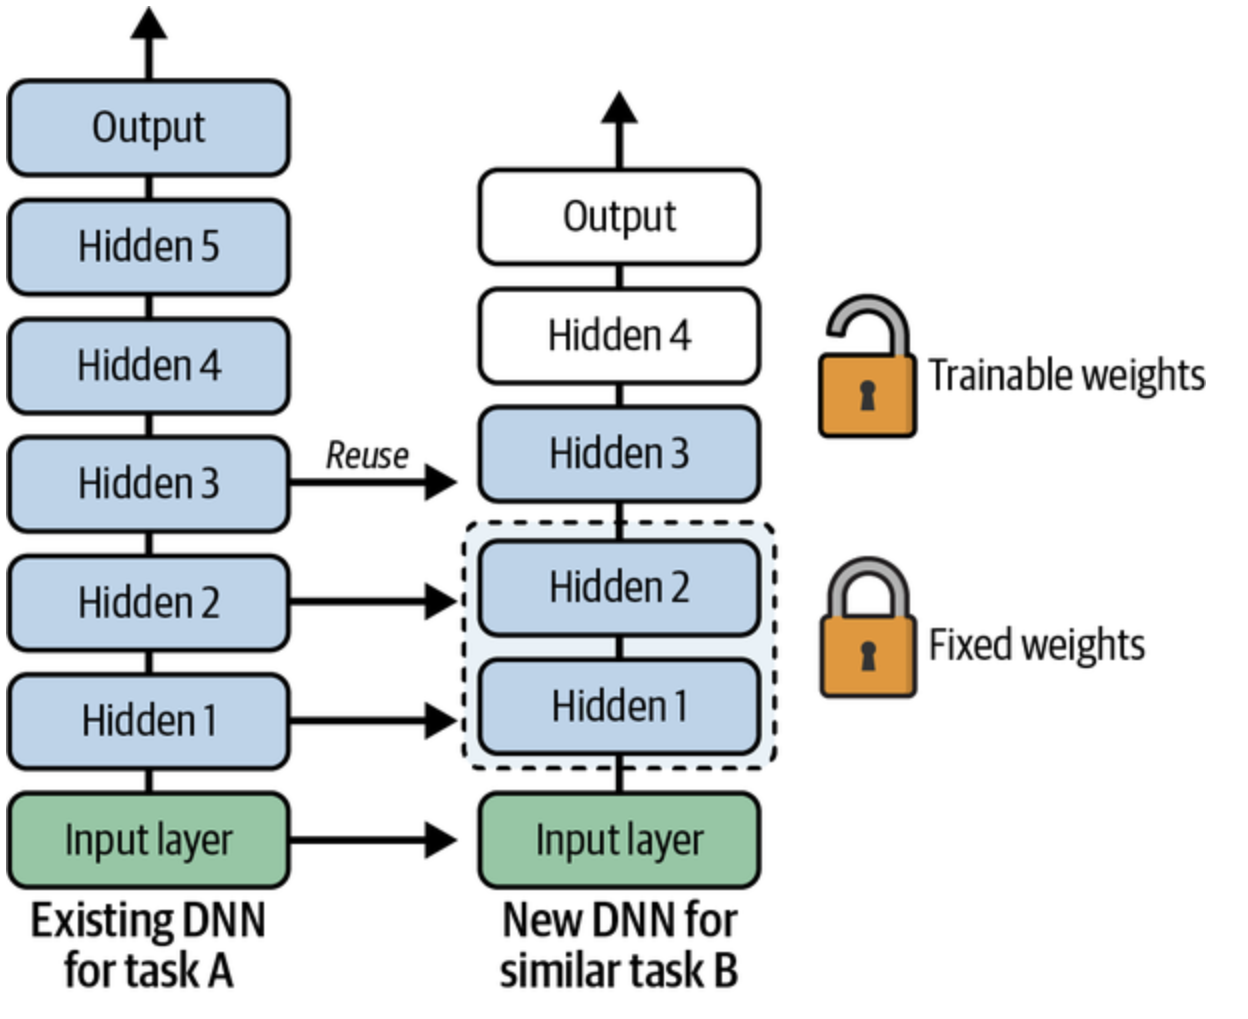

In [1]:
from IPython.display import Image
Image("Figs/transfer_learning.png",width=600)

- For transfer learning to work, your inputs must be in exactly the same format as the existing DNN that you are reusing. For example, if you are re-using a DNN that accepts 30x30 images but your images are 28x28, you have to reshape your features (say, by adding white margins) to be 30x30. Or more generally, you would have to impute missing features.

- The output layer of the existing model is not relevant to your problem (if it is, then your problem is likely to be the same as the problem being solved by the existing DNN). So, you should train the output layer at least.

- Furthermore, the high level hidden layers of the existing DNN are usually not relevant to your problem, as they tend to pick out specific patterns that are more specialized towards the task being solved by the existing DNN.

- The lower level layers are likely to be common between the existing problem and your problem, and you should consider using them.

- So, there is a question of how many lower layers should we "borrow".

- This is also a question of how to reuse the layers:
    - You could just reuse the layers by setting the initial value of the parameters (i.e. the connection weights and other parameters) as given by the existing DNN. Then you still apply backpropogation to train the parameters.
    - You can **freeze** the layer by setting the parameters as in the existing DNN. You don't train the layer's parameters in this approach.

- In general, the more similar your task and the existing DNN task are, the more you can re-use the model. That is, you can use more lower layers and also use more frozen layers.

- A good strategy is to start with re-using many frozen hidden layers. Note the performance on a validation set.

- Then, train the model while unfreezing the higher re-used layers one by one to see if performance improves. When unfreezing the layers, try to use a low learning rate in the GD so that you don't "wreck" the weight of the unfrozen layers.

- If you cannot get any performance boost and you have little training data, try removing the top re-used layer and freeze the remaining layers. Repeat this process until you find the number of layers that yields the best performance.

- If you have a decent amount of training data, you can try replacing the top re-used layer with your own layer (or even add more top layers). See if you get a performance boost. Repeat the process to find a good model.


- Let us illustrate transfer learning using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # Supressing save information/warnings

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

- Let us also define a helper function to set the random seed and reset the TensorFlow backend of Keras.

In [5]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

- Consider the following scenario.

    - Task A: You are given the task of classifying images of 8 fashion items that includes all fashion items except T-shirts/tops (y=0) and pullovers (y=2). You are given the fashion MNIST training set for all the labels except T-shirts/tops and pullovers.

    - Task B: You are given the task of identifying T-shirts/tops (say, positive class) from pullovers (say, negative class). You are only given the fashion MNIST training set for T-shirts/tops and pullovers with only 200 observations.

- So, we have more data for A. Furthermore, A and B are similar in the sense that they are image classifiers.

- Suppose we do Task A. Then we want to reuse the layers of the DNN from Task A to more easily do Task B using transfer learning.

- Let us start with separating the fashion MNIST data set according to the scenario explained above.

In [6]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

- Suppose that you trained the following MLP to solve Task A.

In [ ]:
reset_session()
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

In [14]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])

In [15]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4571 - loss: 1.5435 - val_accuracy: 0.7714 - val_loss: 0.7355
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7846 - loss: 0.6804 - val_accuracy: 0.8300 - val_loss: 0.5422
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8302 - loss: 0.5274 - val_accuracy: 0.8471 - val_loss: 0.4638
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8529 - loss: 0.4544 - val_accuracy: 0.8599 - val_loss: 0.4165
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8639 - loss: 0.4085 - val_accuracy: 0.8666 - val_loss: 0.3855
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8736 - loss: 0.3771 - val_accuracy: 0.8711 - val_loss: 0.3634
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8789 - loss: 0.3542 - val_accuracy: 0.8762 - val_loss: 0.3468
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8838 - loss: 0.3367 - 

- We take a detour on saving and loading Keras models.

- You should save your models so that you don't lose training progress or for reuse in the future.

- You can save Keras models using the .save() method.

In [17]:
from absl import logging
logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

model_A.save("my_model_A.keras")

- This will save a copy of the model on the hard drive (in the local folder). All the parameters (e.g. connection weights, biases etc.) and hyperparameters (e.g. the network structure, the activation functions, optimization routine etc.) will be saved. The model is saved as a folder.

- You can load a saved model using keras.models.load_model() function.

In [18]:
model_A = tf.keras.models.load_model("my_model_A.keras")

- When training large DNNs, it is usual for the training to take hours or even days. What would happen if there is an interruption in the middle of training?

- To avoid being forced to restart the training, you should save the current state of the model at some "check points" during training.

- This is very simple in `Keras`, using the callbacks argument of ``.fit()`` method.

- For example, the following code saves the model at every epoch in the folder ``autosave``.

``checkpoint_cb = keras.callbacks.ModelCheckpoint("autosave")``

``model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint_cb])``

- Let us see how this works. Consider the model you previously trained, which is ``model_A``. When fitting the model, we use the code above to save the model as autosave at the end of each epoch.

- Suppose that there was an interruption and you ended up training the model only for 10 epochs.

In [34]:
reset_session()
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

In [35]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])

In [36]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("autosave.keras")
model_A.fit(X_train_A, y_train_A, epochs=10,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=[checkpoint_cb])

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4373 - loss: 1.5990 - val_accuracy: 0.7566 - val_loss: 0.7392
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.7717 - loss: 0.6876 - val_accuracy: 0.8198 - val_loss: 0.5443
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.8206 - loss: 0.5342 - val_accuracy: 0.8498 - val_loss: 0.4678
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8483 - loss: 0.4645 - val_accuracy: 0.8611 - val_loss: 0.4210
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8612 - loss: 0.4191 - val_accuracy: 0.8711 - val_loss: 0.3877
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8708 - loss: 0.3860 - val_accuracy: 0.8782 - val_loss: 0.3631
Epoch 7/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8786 - loss: 0.3613 - val_accuracy: 0.8817 - val_loss: 0.3449
Epoch 8/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8839 - loss: 0.342

- Since we have saved the model at the end of each epoch, we can simply reload the model and continue training as if the interruption hadn't happened!0

In [37]:
reset_session()
model_A = tf.keras.models.load_model("autosave.keras")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("autosave.keras")
model_A.fit(X_train_A, y_train_A, epochs=10,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=[checkpoint_cb])

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8956 - loss: 0.3045 - val_accuracy: 0.8927 - val_loss: 0.3027
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8991 - loss: 0.2957 - val_accuracy: 0.8945 - val_loss: 0.2965
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9009 - loss: 0.2883 - val_accuracy: 0.8962 - val_loss: 0.2909
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9023 - loss: 0.2817 - val_accuracy: 0.8980 - val_loss: 0.2862
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2759 - val_accuracy: 0.8990 - val_loss: 0.2820
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9060 - loss: 0.2707 - val_accuracy: 0.9005 - val_loss: 0.2784
Epoch 7/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9075 - loss: 0.2660 - val_accuracy: 0.9007 - val_loss: 0.2749
Epoch 8/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9093 - loss: 0.2617 - 

- We can even save a model only if it improves validation accuracy using ``save_best_only=True`` when defining the callback.

- Needless to say, in this case you need to pass a validation set to ``.fit()``.

In [57]:
reset_session()
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])

In [58]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("autosave_best_only.keras",
                                                save_best_only=True)
model_A.fit(X_train_A, y_train_A, epochs=50,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=[checkpoint_cb])

Epoch 1/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5385 - loss: 1.4542 - val_accuracy: 0.7759 - val_loss: 0.6910
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7837 - loss: 0.6441 - val_accuracy: 0.8310 - val_loss: 0.5198
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8363 - loss: 0.5032 - val_accuracy: 0.8521 - val_loss: 0.4450
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8605 - loss: 0.4353 - val_accuracy: 0.8659 - val_loss: 0.4005
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8730 - loss: 0.3933 - val_accuracy: 0.8734 - val_loss: 0.3710
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8810 - loss: 0.3646 - val_accuracy: 0.8797 - val_loss: 0.3502
Epoch 7/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8860 - loss: 0.3438 - val_accuracy: 0.8849 - val_loss: 0.3344
Epoch 8/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8897 - loss: 0.3280 - 

- We can check that the saved model is indeed the one with the best validation loss (i.e. the last epoch).

In [59]:
reset_session()
model_A_best_only = tf.keras.models.load_model("autosave_best_only.keras")

In [60]:
model_A_best_only.evaluate(X_valid_A,y_valid_A)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9167 - loss: 0.2394


[0.22688984870910645, 0.9197794198989868]

- One last handy trick before we continue with the example. You can combine the previous method with the callback `keras.callbacks.EarlyStopping` to implement an early stopping strategy. This callback function terminates training after it measures no improvement in the validation loss function for a fixed number of epochs.

- The patience parameter in `keras.callbacks.EarlyStopping` determines how long we should iterate with no improvement before we stop the training. The min_delta parameter determines how much the validation loss should improve for it to count as an improvement. Setting `restore_best_weights=True` makes `Keras` load the weights of the best model found.

- The following code avoids the long output of ``.fit`` by using the argument verbose=0.

In [61]:
reset_session()
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])

In [63]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_A.keras",
                                                save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=[checkpoint_cb, early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
109,0.947036,0.151906,0.925796,0.212716
110,0.947354,0.151266,0.925796,0.212570
111,0.947695,0.150625,0.925796,0.212473
112,0.947786,0.149985,0.925295,0.212319
113,0.948013,0.149352,0.925295,0.212278
114,0.948308,0.148730,0.925044,0.212164
115,0.948422,0.148106,0.925545,0.212132
116,0.948649,0.147482,0.925796,0.212002
117,0.948899,0.146870,0.925545,0.211964
118,0.949217,0.146269,0.925545,0.211900


- With this approach, we can set the number of epochs to a very large number and then let the early stopping criteria decide when to terminate.

- The early stopping rule kicks in after 119 epochs, it rolls back to the best model in terms of validation loss, which is epoch 109 (this also does not have the lowest validation loss, but it rolls back to it since it is within `min_delta`). The corresponding validation accuracy is 92.57%.

In [64]:
model_A.evaluate(X_valid_A,y_valid_A)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.9219 - loss: 0.2330


[0.21271595358848572, 0.9257959127426147]

- Back to our example. Assume that you have trained and saved your model for Task A (classifying 8 types of images).

- Now you are faced with Task B, which is a binary classification (T-shirts/tops or pullovers), with only 200 training examples.

- Let us see what performance we get by only using this small training set

- Here, we only train for 20 epochs.

In [78]:
reset_session()
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])

logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

In [66]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5462 - loss: 0.7174 - val_accuracy: 0.5776 - val_loss: 0.6968
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6043 - loss: 0.6828 - val_accuracy: 0.6597 - val_loss: 0.6653
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6903 - loss: 0.6489 - val_accuracy: 0.7319 - val_loss: 0.6345
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7575 - loss: 0.6161 - val_accuracy: 0.7873 - val_loss: 0.6056
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8218 - loss: 0.5854 - val_accuracy: 0.8338 - val_loss: 0.5794
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8587 - loss: 0.5578 - val_accuracy: 0.8566 - val_loss: 0.5556
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8808 - loss: 0.5329 - val_accuracy: 0.8754 - val_loss: 0.5339
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8993 - loss: 0.5106 - val_accuracy: 0.8882 - val_loss: 0.5141
Epoch 9

- This binary classification is easier, with 92.78% validation accuracy.

- Let us see if we can improve this performance by transfer learning.

- Let us load our best model for Task A, remove its output layer, and replace it with a new output layer and call this `model_B_on_A`.

In [68]:
reset_session()
model_A = tf.keras.models.load_model("best_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid",
                                    name="new_output"))

- A word of caution. In the above code, `model_A` and `model_B_on_A` share the common layers. If you train `model_B_on_A`, it will also change those layers in `model_A`.

- To avoid this affect, use `keras.models.clone_model()`` function to clone the existing model structure and then load its connection weights in the clone.

In [69]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

- In this example, we don't need model_A. So, we don't need to clone it.

- Now, let us train `model_B_on_A`. Note that the weights of the new output layer are initialized at random. So, if we train it right away, the untrained output layer will make a lot of mistakes and the gradients at the start of training will be large. This may result in wrecking the fine-tuned weights of the lower layers.

- To avoid this, we start by **freezing** all the layers of `model_B_on_A` except the output layer. Then, we train only the output layer for a few epochs.

- For freezing (and unfreezing) to take effect, you must compile the model right after freezing (or unfreezing).

In [70]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2464 - loss: 0.9461 - val_accuracy: 0.2928 - val_loss: 0.9434
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2772 - loss: 0.9068 - val_accuracy: 0.3225 - val_loss: 0.9074
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3469 - loss: 0.8694 - val_accuracy: 0.3640 - val_loss: 0.8738
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3752 - loss: 0.8344 - val_accuracy: 0.4055 - val_loss: 0.8423


- Next, we unfreeze the layers.

In [71]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4352 - loss: 0.7804 - val_accuracy: 0.5470 - val_loss: 0.7276
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5944 - loss: 0.6722 - val_accuracy: 0.6677 - val_loss: 0.6416
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7349 - loss: 0.5876 - val_accuracy: 0.7507 - val_loss: 0.5752
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8005 - loss: 0.5225 - val_accuracy: 0.8002 - val_loss: 0.5229
Epoch 5/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8430 - loss: 0.4714 - val_accuracy: 0.8328 - val_loss: 0.4808
Epoch 6/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8709 - loss: 0.4304 - val_accuracy: 0.8655 - val_loss: 0.4462
Epoch 7/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9113 - loss: 0.3967 - val_accuracy: 0.8803 - val_loss: 0.4173
Epoch 8/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9248 - loss: 0.3683 - val_accuracy: 0.8872 - val_loss: 0.3929
Epoch 9/16
7/7 ━━━

In [72]:
model_B.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.9136 - loss: 0.3841


[0.3851952850818634, 0.9110000133514404]

In [73]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.9328 - loss: 0.2950


[0.2960977852344513, 0.9330000281333923]

- This example is "cherry picked". If you change the training set (e.g. include more observations in Task B, or change classes from T-shirts/tops and pullovers to something else), you may observe that transfer learning doesn't help (or it may even make training harder).

- In general, transfer learning doesn't work well with small dense networks (as in this example). It works best with deep convolutional networks, which we will discuss later.

- However, it may still be beneficial in saving training time.

# 2. Alternative optimization algorithms

- Training a very large DNN can be painfully slow.

- We have seen various methods to speed up training a DNN: resolving the vanishing/exploding gradient problem (for example by using weight initialization, activation functions, BN) and transfer learning.

- A more direct approach is to use better optimization algorithms instead of "vanilla SGD".

## 2.1. Momentum optimization

- GD considers the current value of the gradient when changing the weights. It ignores previous values of the gradient.
$$\begin{align*}
\theta \rightarrow \theta-\eta\nabla_{\theta}J(\theta)
\end{align*}$$

- The **momentum optimization** algorithm uses a weighted average of past and present gradients, called the **momentum**, to change the weights instead.

- The idea is that momentum helps in traversing **valleys** faster, and also helps with skipping local minima.
$$\begin{align*}
\mathbf{m} & \rightarrow \beta\mathbf{m}-(1-\beta)\nabla_{\theta}J(\theta)\\
\theta & \rightarrow \theta-\eta\mathbf{m}
\end{align*}$$

- Let us illustrate this algorithm using Task A in the previous example.

- The following code creates a "base" untrained MLP and saves it. We can then load this model and try it with different algorithms.

- Recall that using vanilla SGD, using the same callback method as Keras to restore the best weights, the best model took 109 epochs with 92.57% validation accuracy.

In [80]:
def build_model(seed=42):
    reset_session(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

- Let us load the base MLP. To use momentum, you can pass the argument `momentum=0.9` to the class `keras.optimizers.SGD`, which can then be passed as the optimizer when compiling the model.

In [81]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

- Let us train the model using momentum and early stopping (same as before).

- The model takes 20 epochs to stop and reaches 92.57% validation accuracy. This is an improvement, at least in terms of run-time.

In [82]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
10,0.939083,0.172419,0.923289,0.221825
11,0.941537,0.166430,0.923289,0.221816
12,0.943582,0.160762,0.923289,0.222747
13,0.945559,0.155482,0.922788,0.221942
14,0.947150,0.150662,0.924542,0.223056
15,0.949126,0.146109,0.923540,0.222018
16,0.950467,0.141715,0.924041,0.223218
17,0.952353,0.137509,0.925295,0.224086
18,0.953739,0.133575,0.924041,0.226576
19,0.955216,0.129813,0.924542,0.228448


## 2.2. Nesterov Accelerated Gradient (NAG)

- NAG is a variant of momentum optimization which almost always performs better than vanilla momentum optimization.

- It follows a very simple idea. The direction of the gradient is better the more near you are to the optimum.

- Thus, instead of using the gradient at the current point, you should use the gradient "slightly ahead".
$$\mathbf{m}\rightarrow \beta\mathbf{m}-(1-\beta)\nabla_{\theta}J(\theta+\beta\mathbf{m})

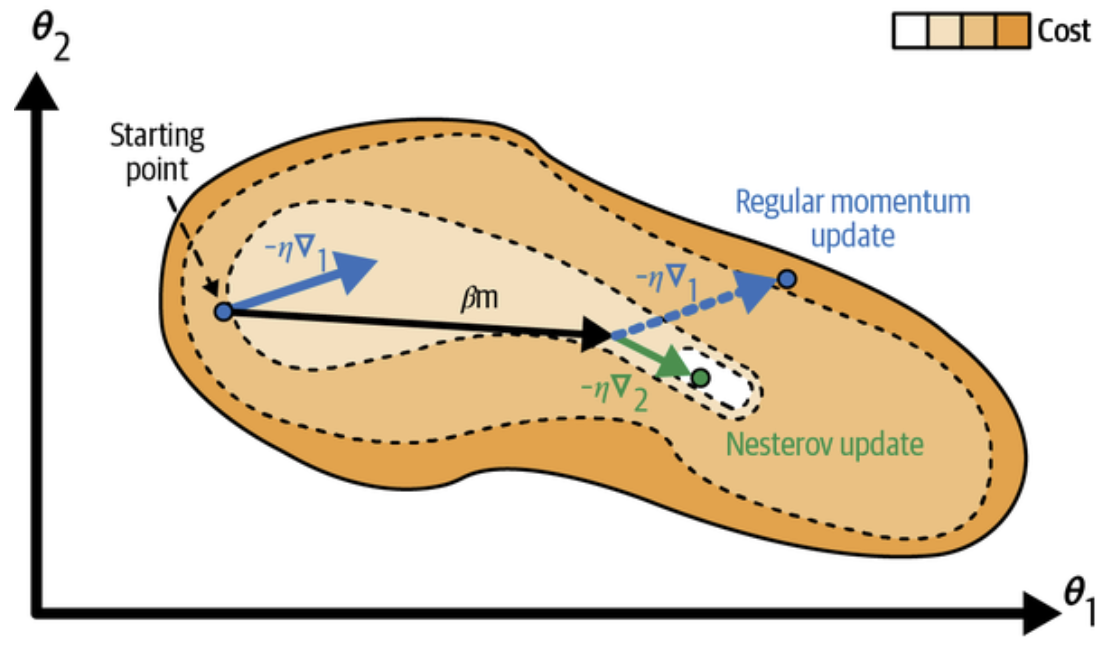

In [83]:
Image("Figs/NAG.png",width=600)

- In Keras, you can use NAG by passing `nesterov=True` to the `keras.optimizers.SGD` class.

In [85]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

- Using the NAG, we get the best model (using early stopping) at epoch 15 with 93.15% accuracy.

In [86]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
15,0.948149,0.146317,0.931562,0.206449
16,0.949763,0.142252,0.931812,0.206380
17,0.951262,0.138102,0.932565,0.206295
18,0.952966,0.134160,0.931562,0.208375
19,0.954648,0.130419,0.931311,0.209162
20,0.955738,0.126955,0.930559,0.209929
21,0.957124,0.123620,0.929807,0.210044
22,0.958965,0.120369,0.929055,0.212714
23,0.960214,0.116995,0.930810,0.214539
24,0.961646,0.113907,0.929306,0.217674


# 2.3. AdaGrad and RMSProp

- Consider the "elongated bowl" problem. Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley

- The AdaGrad algorithm adapts the gradient by scaling down the gradient vector along the steepest coordinate axis. This allows the alogrithm to go more directly towards the minimum.

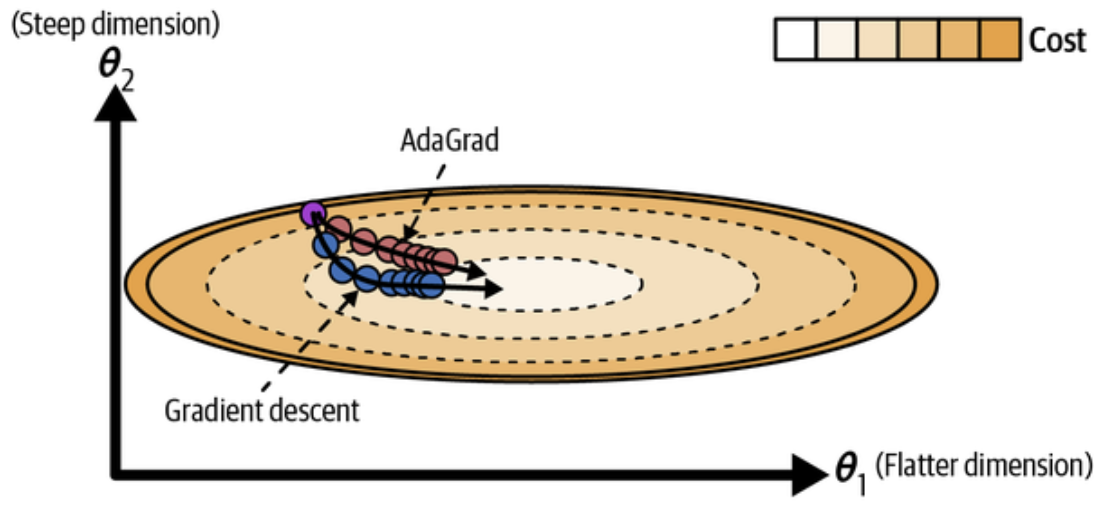

In [87]:
Image("Figs/AdaGrad.png",width=600)

- AdaGrad mitigates this problem by maintaining a scaling factor which becomes larger for larger elements of the gradient, which is used to scale down movements along that coordinate axis. The exact iteration is as follows:
$$\begin{align*}
\mathbf{s} &\rightarrow \mathbf{s}+\nabla_{\theta}J(\theta)\otimes \nabla_{\theta}J(\theta),\\
\theta &\rightarrow \theta-\eta\nabla_{\theta}J(\theta)\ominus\sqrt{\mathbf{s}+\varepsilon}
\end{align*}$$

- Here $\otimes$ is elementwise product and $\ominus$ is elementwise division.

- If a partial derivative suddenly becomes large, then the corresponding element of $\mathbf{s}$ becomes large. When updating the weight, dividing by this element effectively reduces the learning rate for that derivative.

- Unfortunately, AdaGrad does not perform well in training DNNs. The reason is that it often stops training too early due to the scaling down of the learning rate.

- Keras has an AdaGrad optimizer `keras.optimizers.Adagrad`. You should not use it, however.

- Below, we can confirm that the performance of AdaGrad is actually worse than if using vanila SGD in this example.

In [91]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

In [89]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
168,0.943355,0.164857,0.927049,0.217255
169,0.943469,0.164625,0.927300,0.217155
170,0.943582,0.164396,0.927300,0.217066
171,0.943650,0.164161,0.927300,0.216975
172,0.943673,0.163932,0.927300,0.216882
173,0.943764,0.163704,0.927300,0.216779
174,0.943878,0.163478,0.927300,0.216693
175,0.943969,0.163253,0.927300,0.216596
176,0.944059,0.163029,0.927300,0.216502
177,0.944173,0.162810,0.927300,0.216409


- RMSProp algorithm improves AdaGrad by applying an exponential decay to the scale factor. The gradients at the current iteration of $\theta$ are given more weight than at old iterations of $\theta$.
$$\begin{align*}
\mathbf{s} &\rightarrow \rho \mathbf{s}+(1-\rho)\nabla_{\theta}J(\theta)\otimes\nabla_{\theta}J(\theta),\\
\theta &\rightarrow \theta-\eta\nabla_{\theta}J(\theta)\ominus\sqrt{\mathbf{s}+\varepsilon}
\end{align*}$$

- RMSProp is implemented as `keras.optimizers.RMSprop`.

In [92]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

- It works better than AdaGrad in our example. The default hyperparameter value for `rho` ia 0.9, but this can be tuned.

In [93]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
3,0.929768,0.203198,0.921534,0.271682
4,0.933130,0.197190,0.921284,0.284474
5,0.935812,0.189809,0.922036,0.302857
6,0.938175,0.187997,0.916771,0.350540
7,0.940583,0.181128,0.913512,0.352209
8,0.939583,0.178504,0.916019,0.362074
9,0.942991,0.179076,0.917022,0.369981
10,0.943514,0.174868,0.920782,0.409819
11,0.944582,0.174794,0.917022,0.388369
12,0.944900,0.172872,0.918025,0.454352


## 2.4. Adam and Nadam optimizations

- **Adaptive momentum estimation (Adam)** combines the ideas of momentum optimization and RMSProp.

- At iteration $k$
$$\begin{align*}
    \textbf{m} & \rightarrow \beta_1\mathbf{m}-(1-\beta_1)\nabla_{\theta}J(\theta),\\
    \textbf{s} & \rightarrow \beta_2\mathbf{s}-(1-\beta_2)\nabla_{\theta}J(\theta)\otimes \nabla_{\theta}J(\theta),\\
    \hat{\textbf{m}} & \rightarrow \frac{\textbf{m}}{1-\beta_1^k}\\
    \hat{\textbf{s}} & \rightarrow \frac{\textbf{s}}{1-\beta_2^k}\\
    \theta & \rightarrow \theta+\eta\hat{\mathbf{m}}\ominus\sqrt{\hat{\mathbf{s}}+\varepsilon}
\end{align*}$$

- The third and forth steps help at the beginning of the training by enlarging $\textbf{m}$ and $\textbf{s}$ (since they are initialized to be zero).

- Default values are $\beta_1=0.9$ and $\beta_2=0.999$

- We can use the Adam optimizer as follows. It provides better performance.

In [95]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

logging.set_verbosity(logging.ERROR) #This is to suppress some warnings

In [43]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,accuracy,val_loss,val_accuracy
6,0.146948,0.945741,0.200400,0.925545
7,0.139901,0.947536,0.229157,0.929556
8,0.133871,0.949740,0.231695,0.927551
9,0.125611,0.952080,0.227949,0.919529
10,0.121608,0.954352,0.257324,0.931060
11,0.116230,0.956284,0.223776,0.935322
12,0.111142,0.958442,0.217363,0.931060
13,0.108998,0.958579,0.231126,0.934821
14,0.101354,0.962078,0.243912,0.932565
15,0.103155,0.961032,0.240203,0.937077


- **Nesterov Adam (Nadam)* is a variant of Adam with the Nestrov trick, that is replace the first line of Adam with
$$\begin{align*}
    \textbf{m} & \rightarrow \beta_1\mathbf{m}-(1-\beta_1)\nabla_{\theta}J(\theta+\beta_1\mathbf{m}),\\
\end{align*}$$

- It can be used in Keras as follows.

In [96]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

In [97]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
2,0.930086,0.194752,0.924292,0.230556
3,0.936016,0.175742,0.921534,0.235786
4,0.941060,0.162351,0.924542,0.238526
5,0.946354,0.149430,0.922036,0.257381
6,0.949603,0.139078,0.928804,0.235560
7,0.952716,0.130704,0.926047,0.230498
8,0.953898,0.124917,0.925796,0.268582
9,0.956352,0.117851,0.929055,0.262836
10,0.958783,0.112157,0.929556,0.252783
11,0.960146,0.107263,0.928052,0.270622


- There are two further variants of Adam optimization that can be tried.

- **AdaMax** replaces the $\mathbf{s}$ update step with $$\begin{align*} \textbf{s} & \rightarrow \max\{\beta_2\mathbf{s},|\nabla_{\theta}J(\theta)|\},\end{align*}$$ and drops the $\hat{\mathbf{s}}$ update. Scaling down the parameter updates by the maximum value instead of the squares gradients may lead to more stable performance.

In [102]:
model_A = build_model(seed=42)
optimizer = optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
logging.set_verbosity(logging.ERROR) #This is to suppress some warnings
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
7,0.946582,0.150020,0.926799,0.212264
8,0.949513,0.141957,0.925545,0.214003
9,0.951739,0.134178,0.927801,0.213292
10,0.954534,0.127427,0.927300,0.218841
11,0.956602,0.121453,0.926548,0.221642
12,0.959851,0.115417,0.926297,0.224355
13,0.961555,0.109494,0.927049,0.222843
14,0.963850,0.103849,0.928303,0.225706
15,0.965350,0.098863,0.929306,0.227595
16,0.967054,0.094417,0.929055,0.231711


- AdaMax can be implemented using `tf.keras.optimizers.Adamax`.

- **AdamW** includes a regularization technique called weight decay. This reduce the size of the models weights by multiplying them by a decay factor such as 0.99.

- AdamW can be implemented using `tf.keras.optimizers.AdamW`.

In [100]:
model_A = build_model(seed=42)
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
history_adamw = model_A.fit(X_train_A, y_train_A, epochs=200,
            validation_data=(X_valid_A, y_valid_A),
            callbacks=early_stopping_cb, verbose=0)
pd.DataFrame(history_adamw.history).iloc[-11:]

,accuracy,loss,val_accuracy,val_loss
2,0.927973,0.199061,0.928303,0.217344
3,0.934812,0.179269,0.927049,0.217258
4,0.940833,0.163819,0.926297,0.224605
5,0.946036,0.150567,0.926548,0.230565
6,0.948149,0.143335,0.926799,0.237916
7,0.951694,0.131448,0.924041,0.248942
8,0.953966,0.123795,0.927551,0.253559
9,0.956034,0.117615,0.927551,0.254344
10,0.957488,0.114808,0.927551,0.296680
11,0.959692,0.108362,0.931060,0.283365
